In [ ]:
from transformers import AutoTokenizer, pipeline, AutoModelForCausalLM
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import numpy as np
from datasets import load_dataset
from repe import repe_pipeline_registry, WrappedReadingVecModel
import pandas as pd
import gqr

repe_pipeline_registry()

In [ ]:
model_name_or_path = "meta-llama/Llama-3.1-8B-Instruct"

model = AutoModelForCausalLM.from_pretrained(
    model_name_or_path, dtype=torch.float16, device_map="balanced_low_0"
).eval()
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=False)
tokenizer.padding_side = "left"
tokenizer.pad_token = (
    tokenizer.unk_token if tokenizer.pad_token is None else tokenizer.pad_token
)

Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.67it/s]
Some parameters are on the meta device because they were offloaded to the cpu.


In [ ]:
template = """<|begin_of_text|><|start_header_id|>system<|end_header_id|>
You are a helpful assistant<|eot_id|><|start_header_id|>user<|end_header_id|>
{query}<|eot_id|><|start_header_id|>assistant<|end_header_id|>
"""  # prompt template - https://www.llama.com/docs/model-cards-and-prompt-formats/llama3_1/


train_dataset, test_dataset = gqr.load_train_dataset()

train_dataset["text_template"] = train_dataset["text"].apply(
    lambda x: template.format(query=x)
)
test_dataset["text_template"] = test_dataset["text"].apply(
    lambda x: template.format(query=x)
)

# Separate positive and negative examples
train_positive = (
    train_dataset[train_dataset["label"] == 1]
    .sample(n=128, random_state=42)
    .reset_index(drop=True)
)
train_negative = (
    train_dataset[train_dataset["label"] != 1]
    .sample(n=128, random_state=42)
    .reset_index(drop=True)
)

# Create empty lists to store the formatted data
train_data_paired = []
train_labels_paired = []

# Interleave positive and negative examples and their corresponding labels
for i in range(len(train_positive)):
    # Append the positive and negative example sentences
    train_data_paired.append(train_positive.loc[i, "text_template"])
    train_data_paired.append(train_negative.loc[i, "text_template"])

    # Append the corresponding labels for the pair
    train_labels_paired.append([1, 0])

# Update your train_data and train_labels variables
train_data = train_data_paired
train_labels = train_labels_paired

In [6]:
np.array(train_data).shape, np.array(train_labels).shape

((256,), (128, 2))

In [ ]:
rep_token = -1
hidden_layers = list(range(-1, -model.config.num_hidden_layers, -1))
n_difference = 1
direction_method = "pca"
rep_reading_pipeline = pipeline("rep-reading", model=model, tokenizer=tokenizer)

direction_finder_kwargs = {"n_components": 16}

# Set the padding token string
if rep_reading_pipeline.tokenizer.pad_token is None:
    rep_reading_pipeline.tokenizer.pad_token = rep_reading_pipeline.tokenizer.eos_token

# Set the padding token ID
rep_reading_pipeline.tokenizer.pad_token_id = (
    rep_reading_pipeline.tokenizer.eos_token_id
)

rep_reader = rep_reading_pipeline.get_directions(
    train_data,
    rep_token=rep_token,
    hidden_layers=hidden_layers,
    n_difference=n_difference,
    train_labels=train_labels,
    direction_method=direction_method,
    # direction_finder_kwargs=direction_finder_kwargs,
    batch_size=4,
)

Device set to use cuda:0


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


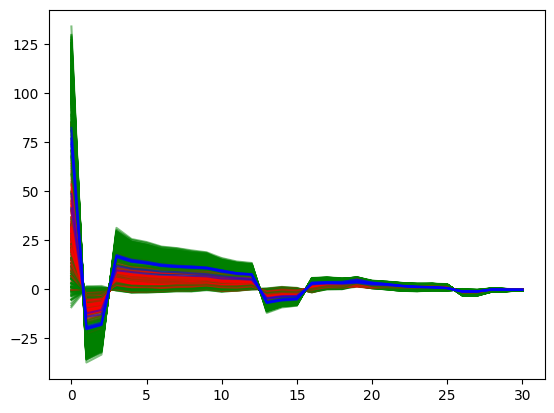

In [ ]:
# Create a color map for your labels.
# Assign a specific color for each label (e.g., 0 and 1).
color_map = {0: "green", 1: "red", 2: "green", 3: "blue"}


for q in range(500):
    new_query = [test_dataset["text_template"].values[q]]
    current_label = test_dataset["label"].values[q]

    # Use the rep_reading_pipeline to get the scores for the new query
    scores = rep_reading_pipeline(
        new_query,
        rep_reader=rep_reader,
        rep_token=rep_token,
        hidden_layers=hidden_layers,
        component_index=0,
    )

    # The 'scores' variable will be a dictionary containing the scores for each layer.
    # The key is the layer, and the value is a numpy array.
    # We need to extract the score for each layer and convert it to a float.
    # We also need to get the color for the current label from the colormap.
    layer_scores = scores[0]

    layer_scores = [float(layer_scores[s][0]) for s in layer_scores]
    color_for_plot = color_map[current_label]

    plt.plot(
        range(len(layer_scores)),
        layer_scores,
        color=color_for_plot,
        label=f"Label: {current_label}",
        alpha=0.5,
    )

# now do harassment / offensive dataset

negative = [
    "this is harassment",
    "I hate you",
    "you are so annoying",
    "this is offensive",
    "I can't stand you",
    "I will kill you!",
    "dement skap",
    "fakt si velky kokot.",
]

for q in negative:
    new_query = [template.format(query=q)]
    current_label = 3

    # Use the rep_reading_pipeline to get the scores for the new query
    scores = rep_reading_pipeline(
        new_query,
        rep_reader=rep_reader,
        rep_token=rep_token,
        hidden_layers=hidden_layers,
        component_index=0,
    )

    layer_scores = scores[0]

    layer_scores = [float(layer_scores[s][0]) for s in layer_scores]
    color_for_plot = color_map[current_label]

    plt.plot(
        range(len(layer_scores)),
        layer_scores,
        color=color_for_plot,
        label=f"Label: {current_label}",
        alpha=0.5,
    )


plt.show()